In [2]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import os

/home/jlaw/.conda/envs/crystals/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/jlaw/.conda/envs/crystals/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/jlaw/.conda/envs/crystals/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


In [3]:
from matminer.featurizers.structure.sites import SiteStatsFingerprint
from sklearn.metrics.pairwise import cosine_similarity
from pymatgen.core import Structure
import glob
import warnings
from tqdm.notebook import tqdm
import os
import pandas as pd
import numpy as np
import dask

In [4]:
os.chdir('../../')
os.getcwd()

'/lustre/eaglefs/projects/rlmolecule/jlaw/crystal-gnn-fork'

In [5]:
from src import utils

In [6]:
# structrual fingerprint using presets from CrystalNN
feat = SiteStatsFingerprint.from_preset("CrystalNNFingerprint_ops")

name_list_unrelax = []
vect_list_unrelax = []
name_list_relax = []
vect_list_relax = []

In [7]:
# load in the oqmd unrelaxed and relaxed datasets
# unrelaxed_strcs_file = "inputs/oqmd-structures/oqmdv1_4-unrelaxed-structures.json.gz"
# unrelaxed_strcs = utils.load_structures_from_json(unrelaxed_strcs_file)
# start with the zintl structures 
unrelaxed_strcs_file = "inputs/structures/zintl_unrelaxed_structures.json.gz"
unrelaxed_strcs = utils.load_structures_from_json(unrelaxed_strcs_file)

# relax_strcs_file = "inputs/oqmd-structures/oqmdv1_4-relaxed-structures.json.gz"
# relaxed_strcs = utils.load_structures_from_json(relax_strcs_file)

Loading inputs/structures/zintl_unrelaxed_structures.json.gz
	11028 loaded


In [8]:

# PSJ: Largely following Noel's script here for the configuration

n_processes = 18  # number of processes to run on each node
memory = 90000  # to fit on a standard node; ask for 184,000 for a bigmem node

cluster = SLURMCluster(
    project='rlmolecule',
    walltime='30',  # 30 minutes to fit in the debug queue; 180 to fit in short
    job_mem=str(memory),
    job_cpu=36,
    interface='ib0',
    local_directory='/tmp/scratch/dask-worker-space',
    cores=18,
    processes=n_processes,
    memory='{}MB'.format(memory),
    queue='debug'  # Obviously this is limited to only a single job -- comment this out for larger runs
)

print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p debug
#SBATCH -A rlmolecule
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=90000
#SBATCH -t 30

/home/jlaw/.conda/envs/crystals/bin/python -m distributed.cli.dask_worker tcp://10.148.8.97:41792 --nthreads 1 --nprocs 18 --memory-limit 4.66GiB --name dummy-name --nanny --death-timeout 60 --local-directory /tmp/scratch/dask-worker-space --interface ib0 --protocol tcp://



In [9]:
# Create the client
dask_client = Client(cluster)

In [10]:
n_nodes = 1 # set this to the number of nodes you would like to start as workers
cluster.scale(n_processes * n_nodes)

In [11]:
unrel_df = pd.DataFrame(pd.Series(unrelaxed_strcs))
unrel_df.head(2)

,0
NaSnBi_NaCdAs_62_1,"[[8.07542632 7.24782238 1.204686 ] Na, [0.089..."
sg192_icsd_181463_KAs_2,"[[-2.05950076 5.6255173 0. ] K, [0.9..."


In [12]:
len(unrel_df)

11028

In [13]:
example_feat = feat.featurize(list(unrelaxed_strcs.values())[0])

/home/jlaw/.conda/envs/crystals/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4135: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/jlaw/.conda/envs/crystals/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:3938: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(


In [20]:
import dask.dataframe as dd
df_dask = dd.from_pandas(unrel_df[:1000], npartitions=n_nodes*n_processes)

In [21]:
meta = pd.Series([example_feat])
results = df_dask.map_partitions(lambda x: x[0].apply(feat.featurize), meta=meta)

This is the big computation. you can monitor it by going to http://localhost:1235/proxy/8787/status (replace 1235 with whatever your local jupyterlab tunnel is routed to. 8787 is the default port. It should tell you a different port if that's already taken)). More info here: https://jobqueue.dask.org/en/latest/interactive.html

In [22]:
finished = results.compute()

In [23]:
finished

BaAs4_071579_sg43          [0.35637312879731364, 0.4166575879033287, 0.35...
BaAs4_165263_sg12          [0.34662236452750317, 0.4245239632646854, 0.34...
BaBi4_065415_sg15          [0.22311649943527678, 0.26355028493549437, 0.2...
BaSb4                      [0.13773282203004308, 0.16865657786621405, 0.1...
BaSb4_002492_sg2           [0.19527388093025913, 0.22563781529742957, 0.1...
                                                 ...                        
sg84_icsd_061063_KAs       [0.00015175153776040128, 0.0001517515377604012...
sg84_icsd_061063_KBi       [0.00015175153776040128, 0.0001517515377604012...
sg84_icsd_061063_LiAs_2    [0.00015175153776040128, 0.0001517515377604012...
sg92_icsd_078162_LiSb      [0.00391748039568643, 0.004814578662572201, 0....
sg99_icsd_107010_RbSb      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Length: 1000, dtype: object

## Cosine similarity
TODO Now compute the cosine similarity between the unrelaxed and relaxed structures

In [5]:
cos_list = []
i = 0

for names in name_list_relax:
    print(names)
    try:
        # calculate the cos similairty for unrelaxed/relaxed pair
        cos_sim = cosine_similarity([relax_dic[str(names)]],[unrelax_dic[str(names)]])
        cos_list.append(cos_sim[0][0])
        i += 1
    except:
        print('No matching relaxed structure!')

print('# of materials with cosine similarity:', len(cos_sim))

K3Y1O3_sg12_icsd_047111_2
K1B1Al1Br5S1_sg2_icsd_413818_20
K1Ti1Zn2N3_sg11_icsd_412372_1
K1Zn1B1N1P1_sg62_icsd_409579_60
K3La3P4_sg14_icsd_014049_2
K1Sb1N2_sg25_icsd_093041_1
K1Cl1_sg42_icsd_069042_2
K1Cl1_sg40_icsd_002431_2
K1Cd1Al1N1P1_sg11_icsd_094400_57
K1La1Cl2Br2_sg139_icsd_056653_4
K1Hf1Sn1N3_sg55_icsd_249402_5
K3N1_sg223_icsd_052472_1
K5S1P1_sg63_icsd_073314_2
K1Sc2Cd1I1O4_sg33_icsd_032709_6
K1Hg1Al1N1P1_sg62_icsd_409579_13
K2La1Br5_sg6_icsd_092314_1
K2Zn3S4_sg12_icsd_074903_1
K1Cd1Ge1F1I6_sg4_icsd_159098_21
K1Cd1Hg1O1N1_sg11_icsd_094400_56
K1Hf1Sn1N3_sg121_icsd_028222_1
K6O1S2_sg2_icsd_405774_1
K1Sn1Br2N1_sg61_icsd_063002_5
K1Br1_sg191_icsd_161110_1
K6O1S2_sg53_icsd_200677_1
K1Sb1N2_sg112_icsd_073376_2
K3La2N3_sg134_icsd_085305_2
K1Sn1Br2N1_sg2_icsd_171429_3
K1La1Si1Br6O1_sg12_icsd_172413_1
K1La1Zn1Cl3N1_sg187_icsd_154684_19
K2Zn1Ge2N2P2_sg139_icsd_088424_9
K1Zr1Zn1F5O1_sg13_icsd_085759_10
K1Zr1Zn1F5O1_sg14_icsd_168616_7
K4W1S5_sg87_icsd_020452_1
K1Br1_sg187_icsd_073387_1
K1Cd1

In [6]:
flat_list = []
flat_list = [row for row in zip(name_list_relax, cos_list)]
df = pd.DataFrame(flat_list, columns=['structure', 'cos_similarity'])
df.to_csv('cos_sim.csv')

Text(0.5, 1.0, 'KAlI4: toal # of structures 186')

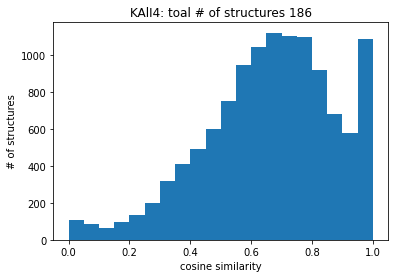

In [7]:
from matplotlib import pyplot as plt
plt.hist(cos_list, 20)
plt.xlabel('cosine similarity')
plt.ylabel('# of structures')
plt.title('KAlI4: toal # of structures 186')